##### 1. Problem statement:
 * Generate Topics for the reviews: 
    * From the reviews of the product , we want to generate the top topics in the reviews . 
    * Algorithm for generating topic:
        * For each Product , separate positive and negative reviews based on the review score
            * For given product and sentiment(positive):
                1. Clean the documents
                2. Extract Top Key words in each document
                3. Convert all the Top Key words into BERT embeddings
                4. Cluster the words into K clusters(We chose 5 for explainability)  
                5. For each cluster, use the representative documents , generate topic using LLM

 * Summary Generation
    * For each Product , separate positive and negative reviews based on the review score
        * For given product and sentiment(positive):
            1. Clean the documents
            2. Extract Top Key words in each document
            3. Convert all the Top Key words into BERT embeddings
            4. Cluster the words into K clusters 
            5. For each cluster, use the representative documents , generate summary using LLM


In [ ]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
%matplotlib inline
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from keybert import KeyBERT
from google import genai
from google.genai import types

* Provide Google AI API Key for LLM

In [ ]:
API_KEY = "YOUR_API_KEY" # Replace with your actual API key


#### 2.Data Preparation

In [194]:
review_df=pd.read_csv("./data/amazon_reviews.csv")

In [375]:
review_df.dtypes

asins                object
reviews.rating      float64
name                 object
brand                object
categories           object
reviews.text         object
reviews.title        object
reviews.username     object
dtype: object

In [195]:
review_df.head(5)

asins  reviews.rating  \
0  B00QWO9P0O,B00LH3DMUO             3.0   
1  B00QWO9P0O,B00LH3DMUO             4.0   
2  B00QWO9P0O,B00LH3DMUO             5.0   
3  B00QWO9P0O,B00LH3DMUO             5.0   
4  B00QWO9P0O,B00LH3DMUO             5.0   

                                                name         brand  \
0  AmazonBasics AAA Performance Alkaline Batterie...  Amazonbasics   
1  AmazonBasics AAA Performance Alkaline Batterie...  Amazonbasics   
2  AmazonBasics AAA Performance Alkaline Batterie...  Amazonbasics   
3  AmazonBasics AAA Performance Alkaline Batterie...  Amazonbasics   
4  AmazonBasics AAA Performance Alkaline Batterie...  Amazonbasics   

                                          categories  \
0  AA,AAA,Health,Electronics,Health & Household,C...   
1  AA,AAA,Health,Electronics,Health & Household,C...   
2  AA,AAA,Health,Electronics,Health & Household,C...   
3  AA,AAA,Health,Electronics,Health & Household,C...   
4  AA,AAA,Health,Electronics,Health & Household,C...   

                                        reviews.text  \
0  I order 3 of them and one of the item is bad q...   
1  Bulk is always the less expensive way to go fo...   
2  Well they are not Duracell but for the price i...   
3  Seem to work as well as name brand batteries a...   
4  These batteries are very long lasting the pric...   

                                       reviews.title  reviews.username  
0  ... 3 of them and one of the item is bad quali...        Byger yang  
1  ... always the less expensive way to go for pr...              ByMG  
2  ... are not Duracell but for the price i am ha...  BySharon Lambert  
3  ... as well as name brand batteries at a much ...     Bymark sexson  
4  ... batteries are very long lasting the price ...           Bylinda

In [7]:
#### Remove Nulls
review_df_cleaned=review_df[~review_df['reviews.text'].isnull()].copy()

In [8]:
#Remove reviews with more than > 400 words  due to token limitation of Sentence Transformers
review_df_cleaned['token_count'] = review_df_cleaned['reviews.text'].apply(lambda x: len(x.split()))
review_df_cleaned=review_df_cleaned[review_df_cleaned['token_count']<=400]

#### 3.Data Visualization

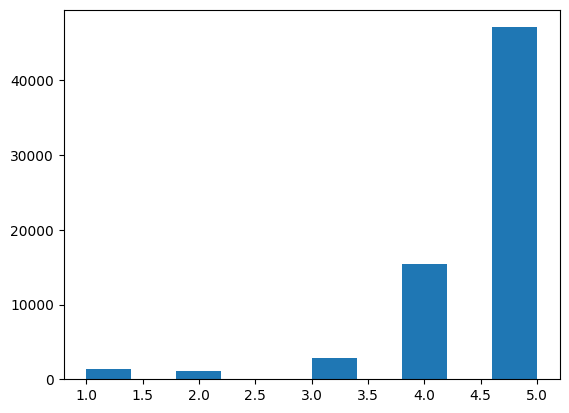

In [16]:
import matplotlib.pyplot as plt
plt.hist(review_df_cleaned['reviews.rating'])
plt.show()

* Due to cost of LLM API calls,  Filtered Products with reviews more than 1000

In [ ]:
asinCount=pd.DataFrame(review_df_cleaned['asins'].value_counts())
products_with_more_than_1000_reviews= asinCount[asinCount['count']>1000].index.values

* List of Products for Topic Modelling

In [143]:
products_with_more_than_1000_reviews

array(['B018Y229OU', 'B00QWO9P0O,B00LH3DMUO', 'B00L9EPT8O,B01E6AO69U',
       'B00U3FPN4U', 'B00QWO9P0O,B01IB83NZG,B00MNV8E0C', 'B01AHB9CN2',
       'B00OQVZDJM', 'B018Y23MNM', 'B018Y225IA', 'B018T075DC',
       'B018SZT3BK,B01AHB9CN2', 'B018Y22C2Y', 'B018Y226XO', 'B01BH83OOM',
       'B018Y22BI4', 'B00IOY8XWQ'], dtype=object)

#### 4.Models

In [ ]:
#Models Used for Topic Modeling and Keyword Extraction
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = SentenceTransformer(model_name)
kw_model = KeyBERT(model)

No sentence-transformers model found with name distilbert-base-uncased-finetuned-sst-2-english. Creating a new one with mean pooling.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Initialize the Google GenAI client
client = genai.Client(api_key=API_KEY)

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Utility Function to clean text data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return " ".join([word for word in text.split() if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manikandanperumal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [364]:
def generateTopicUsingLLM(input: list,productName: str):
    """
        Args:
            input (list): List of  review 
            productName (str):  Name of the product 
        
        Returns :
            str :  summary 
    """
    prompt = f""" 
                Build a topic of  discussion based on the reviews.
                
                Instruction : 
                Given list of documents suggest a meaningful topic
                Generate  a simple topic.  Nothing else.
                Dont mention the product name. 
            
                Product Name :  {productName}
                
                Top Key Words to build summary :
                {[ i for i in input]}
             
            """
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt,
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0) 
        ),
    )
    return response.text

In [366]:
def generateTopKeywords(input: list,ngram_range: tuple =(3,4)):
    """_summary_

    Args:
        input (list): list of sentences

    Returns:
        list: List ot Top N=1 Keywords
    """
    kw_model = KeyBERT(model)
    keywords = kw_model.extract_keywords(input, keyphrase_ngram_range=ngram_range, stop_words='english', top_n=1)
    return [ j[0] for i in keywords for j in i]

def generateTopics(top_keywords: list,n_clusters:int =5):
    """
    Args:
        top_keywords (list): List of  Key Words to be clustered
        
    Returns :
        list :  List of topics 
    """
    embeddings = model.encode(top_keywords)
    # Use KMeans clustering 
    kmeans_model = KMeans(n_clusters, random_state=42)
    # Create BERTopic model with KMeans
    topic_model = BERTopic(embedding_model=model, vectorizer_model=CountVectorizer(), 
                        nr_topics=None, calculate_probabilities=True, verbose=False, 
                        low_memory=True, min_topic_size=1, umap_model=None, hdbscan_model=kmeans_model)

    topic_model.fit_transform(top_keywords, embeddings)

    # Display topics
    topic_info = topic_model.get_topic_info()
    return topic_info

In [367]:
def generateTopicDataFrame(reviews: list, productName: str,isPositive: bool=True):
    """
    Generate topics from a list of reviews using BERTopic and LLM.
    Args:
        reviews (list): List of review texts.
        productName (str): Name of the product.
        isPositive (bool): Flag indicating if the sentiment is positive.
    Returns:
        pd.DataFrame: DataFrame containing topics, representative documents, and generated topics.
    """
    cleaned_reviews=[clean_text(r) for r in reviews]
    key_words=generateTopKeywords(cleaned_reviews,ngram_range=(2,3))
    # print(key_words)
    topics=generateTopics(key_words,n_clusters=5)
    topicsGenerated=[]
    for docs in topics['Representative_Docs']:
        topic=generateTopicUsingLLM(docs,'Amazon Fire Tablet')
        # print(topic)
        topicsGenerated.append(topic)
    topics['generatedTopic']=topicsGenerated
    topics['isPositiveSentiment']= isPositive
    topics['product']=productName
    return topics

In [368]:
topicModel_df=pd.DataFrame()

#### 4.1 Topic Modeling

In [369]:
# 3. Topic modeling 
for productAsin in products_with_more_than_1000_reviews:
    product=review_df_cleaned[review_df_cleaned['asins']==productAsin].copy()
    product.reset_index(inplace=True)
    productName=product['name'][0]
    print(f"Processing product: {productName}" )
    cons=product[product['reviews.rating']<3]['reviews.text'].values
    df=generateTopicDataFrame(cons,productName=productName,isPositive=False)
    topicModel_df=pd.concat([topicModel_df,df],axis=0)
    pros=product[product['reviews.rating']>=3]['reviews.text'].values
    df=generateTopicDataFrame(pros,productName=productName,isPositive=True)
    topicModel_df=pd.concat([topicModel_df,df],axis=0)
    
 

Processing product: Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta
Processing product: AmazonBasics AAA Performance Alkaline Batteries (36 Count)
Processing product: Echo (White),,,
Echo (White),,,
Processing product: nan
Processing product: AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary
Processing product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Processing product: Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,
Processing product: Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case
Processing product: Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers
Processing product: Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers
Processing product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black
Processing product: Fire Kids Ed

In [372]:
topicModel_df.head(10)

Topic  Count                              Name  \
0      0    113            0_ads_tablet_slow_apps   
1      1     62  1_cheap_slow_disappointed_tablet   
2      2     57     2_tablet_wifi_amazon_returned   
3      3     51       3_didnt_dont_wouldnt_doesnt   
4      4     44          4_price_good_size_memory   
0      0   2853          0_tablet_easy_use_bought   
1      1   2704        1_tablet_cheap_little_dont   
2      2   2203         2_great_good_tablet_price   
3      3   1727        3_loves_love_gift_daughter   
4      4   1139        4_tablet_amazon_use_kindle   

                                      Representation  \
0  [ads, tablet, slow, apps, half, tube, internet...   
1  [cheap, slow, disappointed, tablet, bad, got, ...   
2  [tablet, wifi, amazon, returned, device, need,...   
3  [didnt, dont, wouldnt, doesnt, like, really, w...   
4  [price, good, size, memory, purchase, kindle, ...   
0  [tablet, easy, use, bought, price, kids, games...   
1  [tablet, cheap, little, dont, doesnt, price, b...   
2  [great, good, tablet, price, nice, product, pe...   
3  [loves, love, gift, daughter, bought, son, chr...   
4  [tablet, amazon, use, kindle, easy, apps, like...   

                                 Representative_Docs  \
0  [bothered ads tablet, internet slow tablet, sl...   
1  [wanted cheap tablet, cheap tablet amazon, tab...   
2  [spend device barely, problem work wifi, table...   
3  [dont like tablet, didnt like return, didnt like]   
4  [recommend memory card, purchase price, takes ...   
0       [tablet easy, kids easy use, easy use price]   
1  [great tablet dont, little tablet price, cheap...   
2  [great tablet price, great tablet price, good ...   
3  [gift daughter loves, loves tablet, loves tablet]   
4       [tablet easy use, use tablet, amazon tablet]   

                                      generatedTopic  isPositiveSentiment  \
0                     Performance and Advertisements                False   
1                          Affordable Tablet Options                False   
2  Frequent device malfunctions and poor Wi-Fi co...                False   
3              Customer Dissatisfaction with Tablets                False   
4            Good value for an entertainment tablet.                False   
0              User-friendliness and Value for Money                 True   
1                       Affordable Tablet Experience                 True   
2                Value and affordability of tablets.                 True   
3                               Popularity as a Gift                 True   
4        Ease of Use and Everyday Utility of Tablets                 True   

                                             product  
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
1  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
2  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
3  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
4  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
1  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
2  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
3  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  
4  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...

In [373]:
topicModel_df.to_csv("./amazon_topic_modeling.csv",index=False)

#### 4.2 Product Summary Generation

In [ ]:
# embeddings
# kmeans_model = KMeans(n_clusters=5, random_state=42)

In [241]:
def generateSummary(input: list,productName: str):
    """
        Args:
            input (list): List of  review 
            productName (str):  Name of the product 
        
        Returns :
            str :  summary 
    """
    keywords= generateTopKeywords(input)
    topic_info=generateTopics(keywords)
    productName= product['name'][0]
    prompt = f""" 
                Build A summary on the product using the key attributes mentioned on the reviews.
                
                Instruction : Top keywords is in a list of topic. Each topic has a group of ket attributes about the topic.
                First think of   simple sentence for each topic. Dont repeat the topic keywords.Then create a crisp summary based on the all
                sentences generated. Limit the summary to a maximum of 5 sentences.
                
                Generate response only with the summary.  Nothing else.
                
                Produt Name :  {productName}
                
                Top Key Words to build summary :
                {[ i for i in topic_info['Representation'] ]}
                """
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt,
        config=types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(thinking_budget=0) 
        ),
    )
    return response.text


In [201]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generateWordCloud(topic_info,productName,isPositive: bool=True):
    list_of_lists = topic_info['Representation']

    # Flatten the list of lists into a single list
    flattened_words = [word for sublist in list_of_lists for word in sublist]

    # Join the words into a single string
    text = " ".join(flattened_words)
    strSentiment= "Positive" if isPositive else "Negative"
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    productName=product['name'][0]
    # Display it
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{productName} {strSentiment} Reviews')
    plt.show()


##### 5. Results
 *  Visualization of Topics in Negative and Positive Reviews per product.

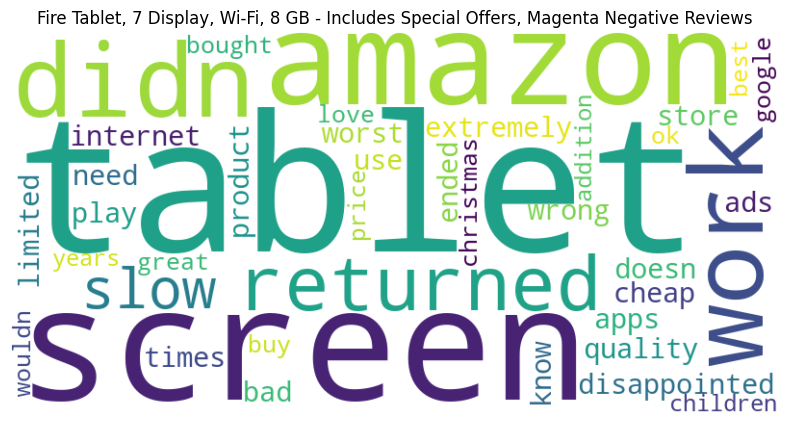

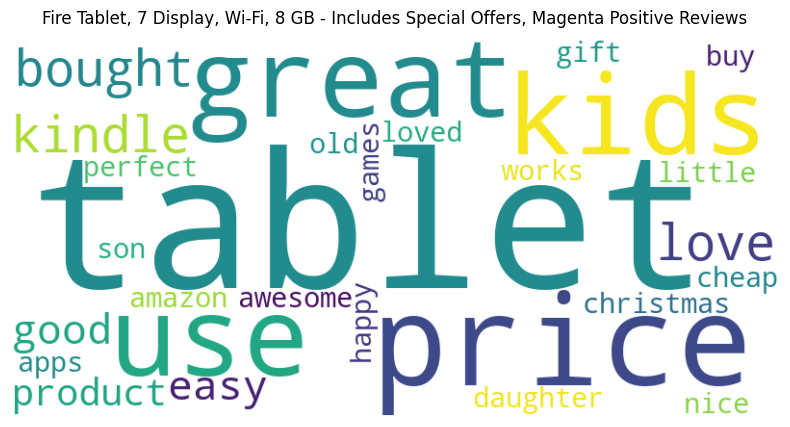

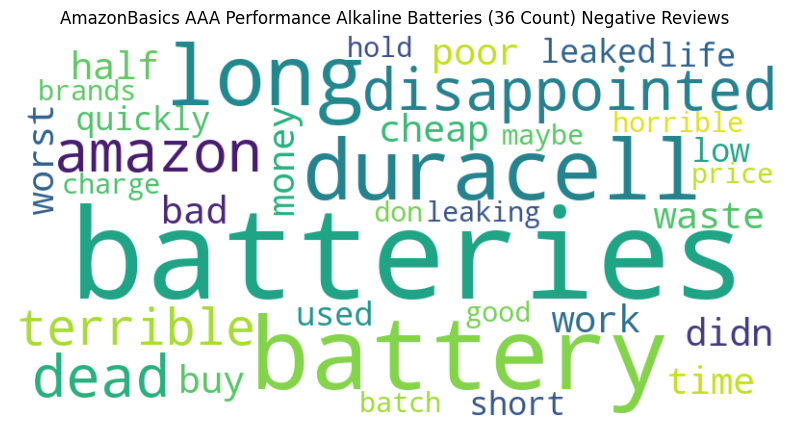

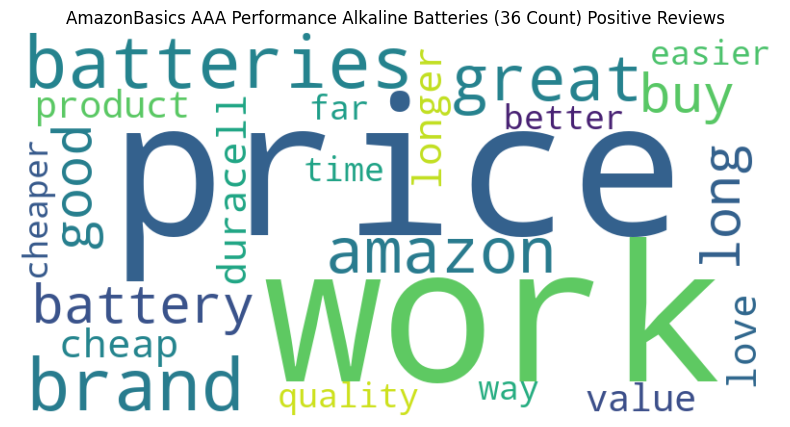

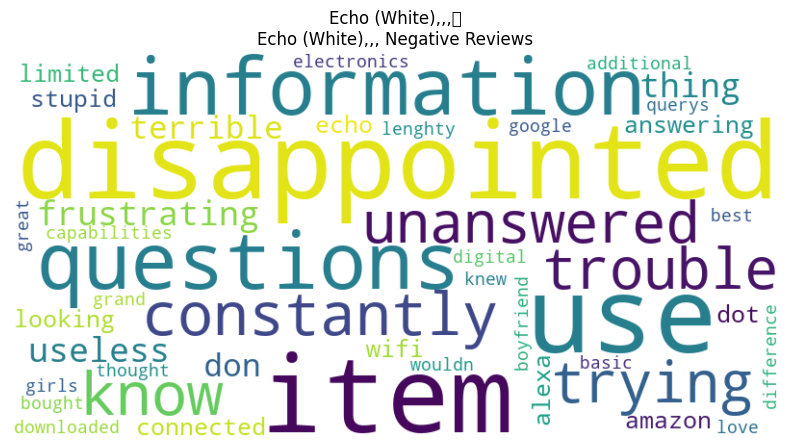

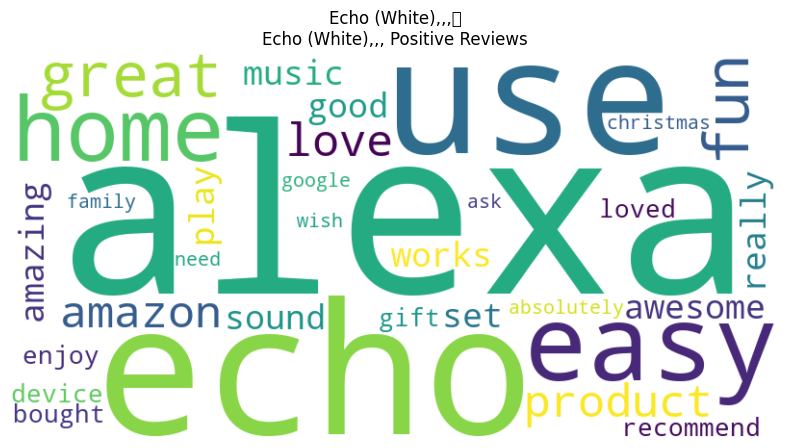

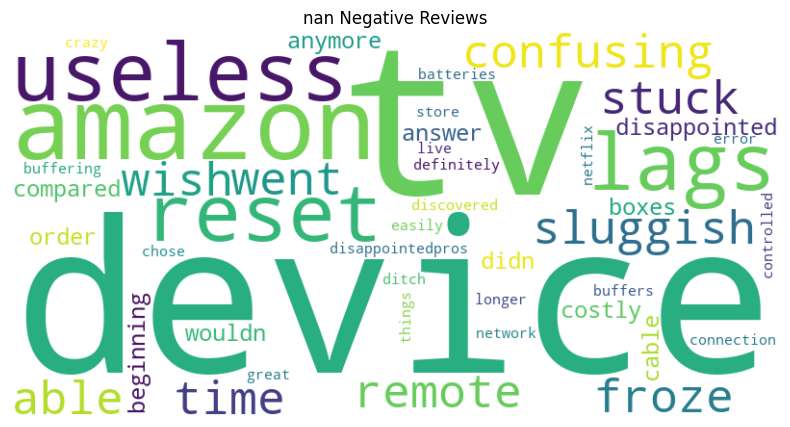

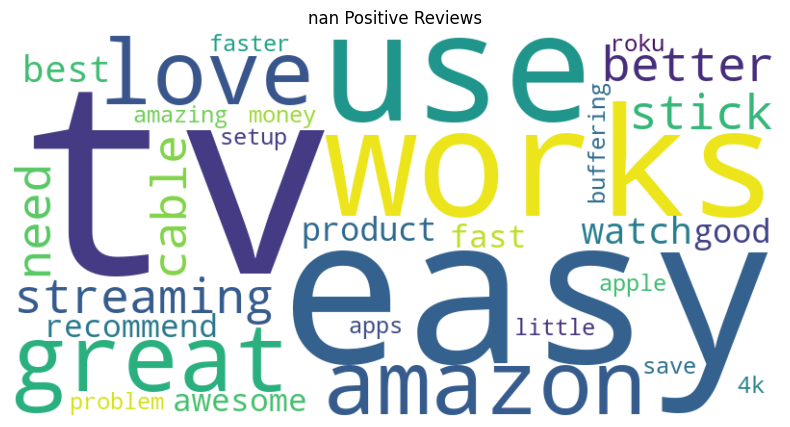

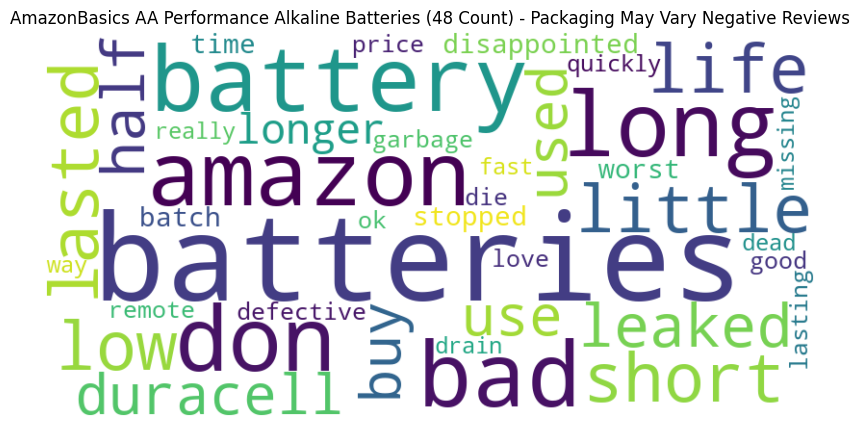

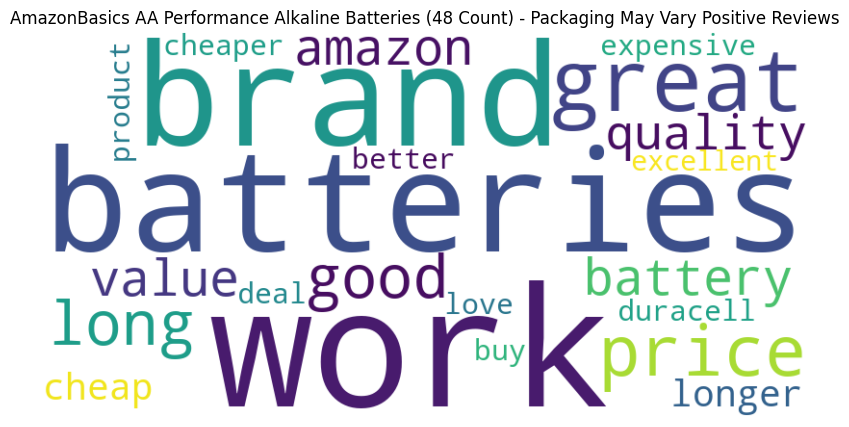

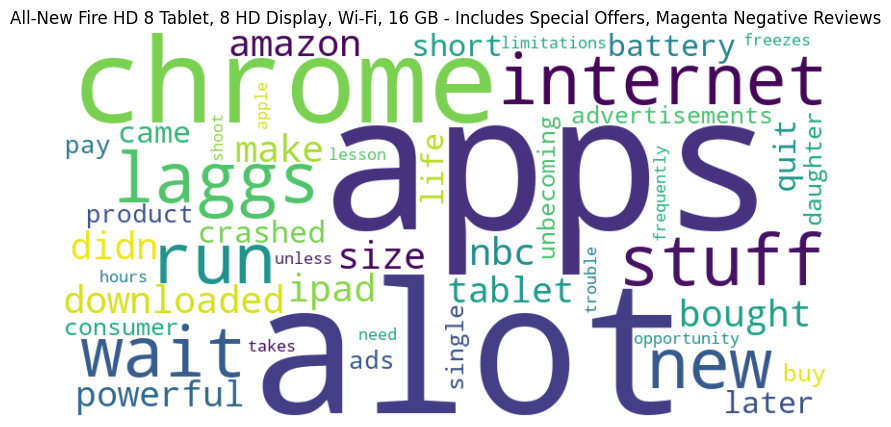

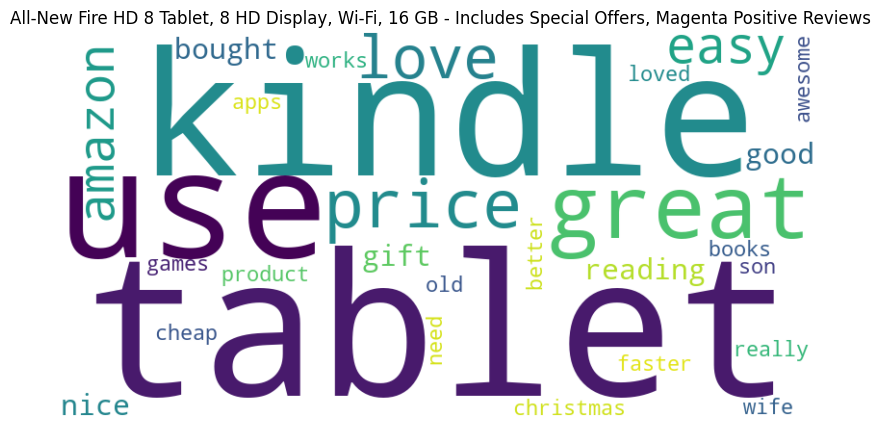

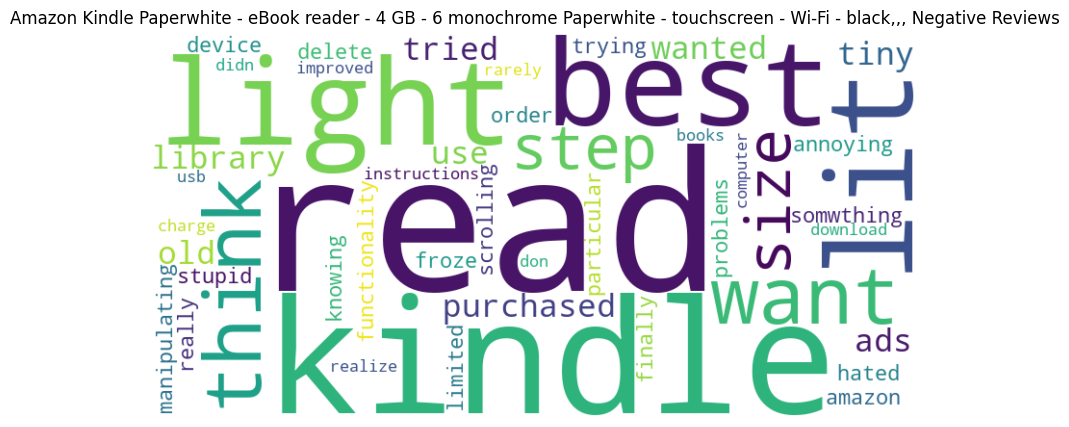

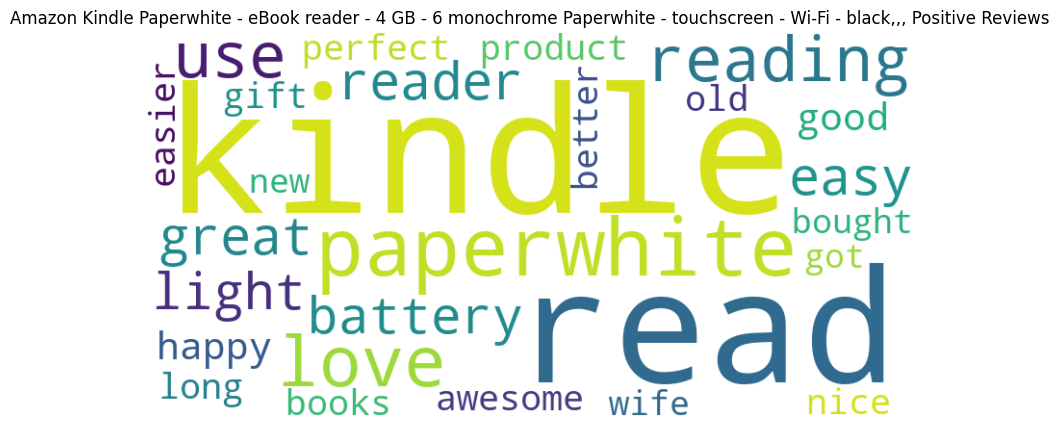

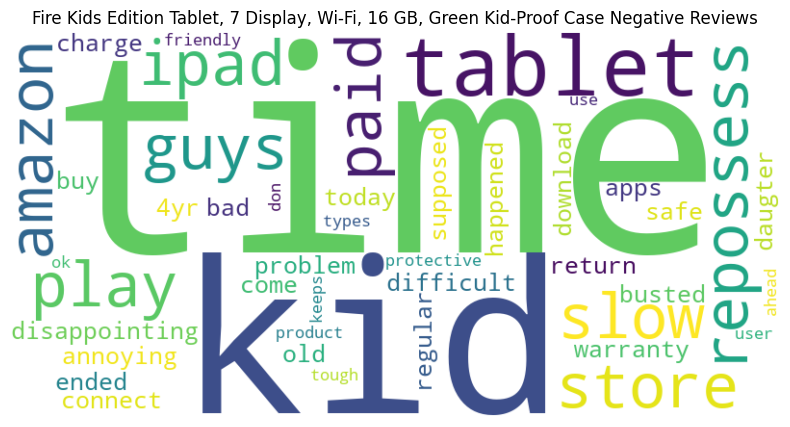

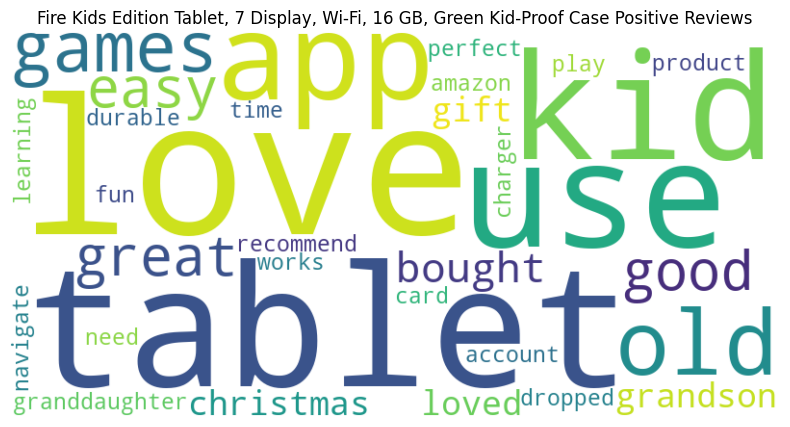

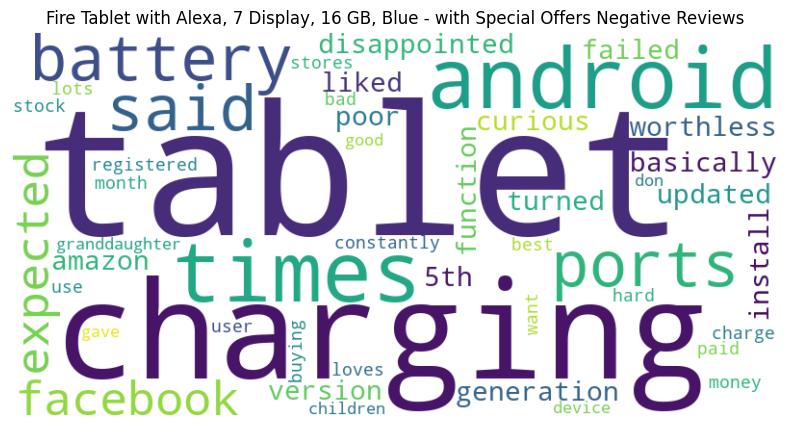

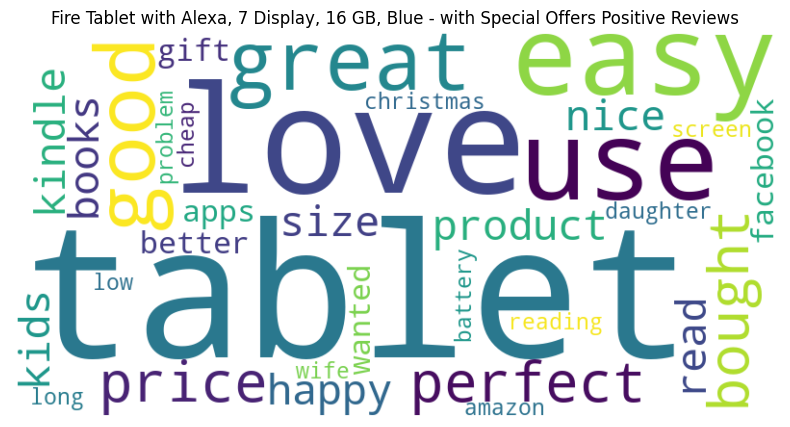

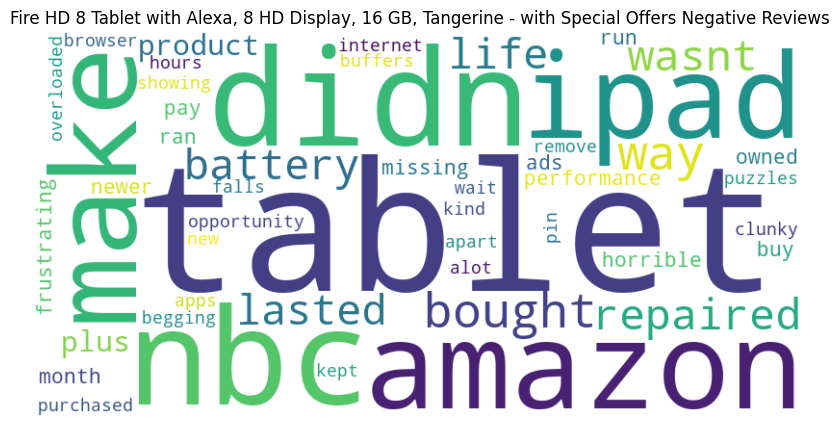

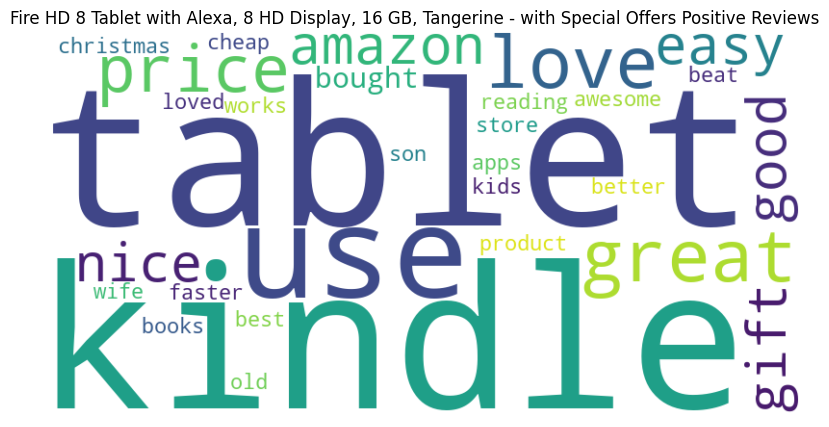

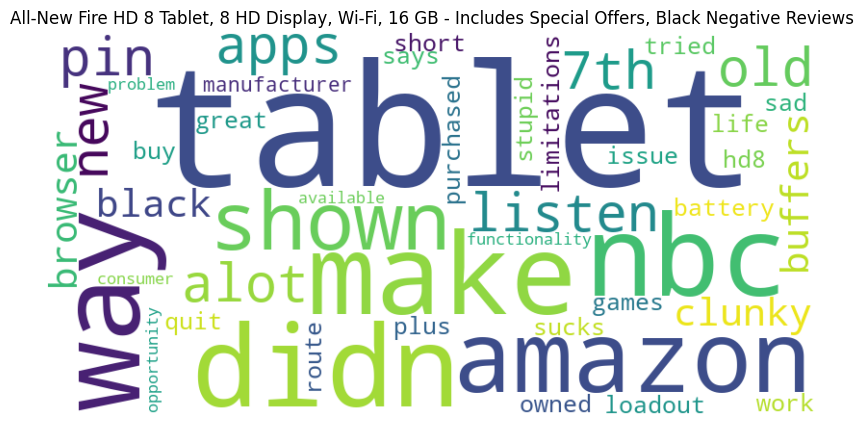

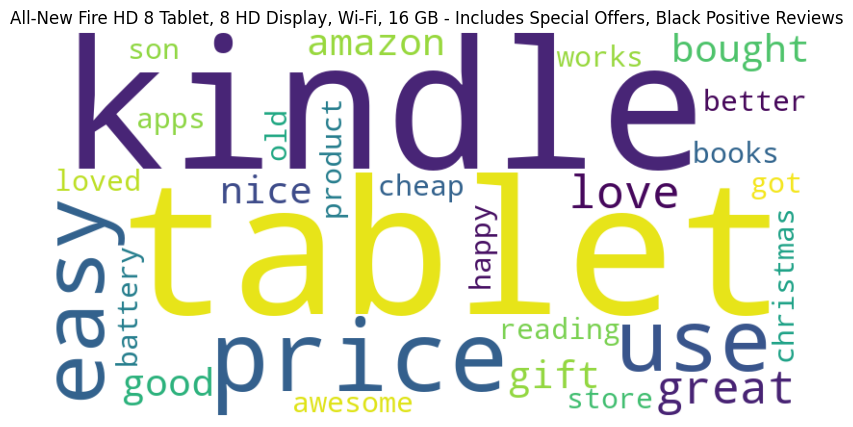

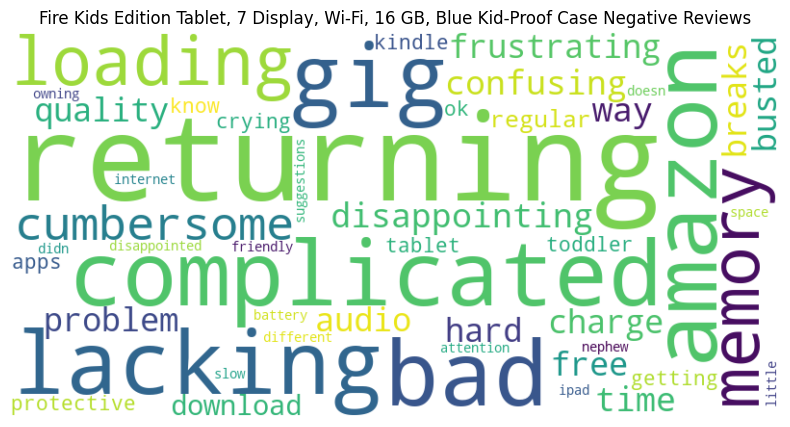

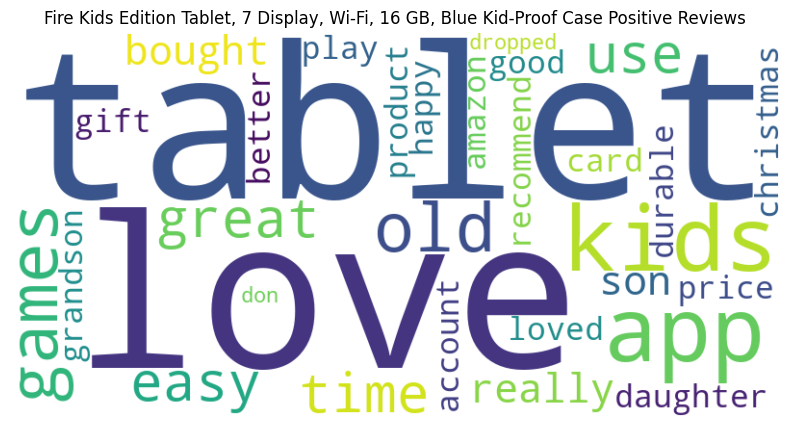

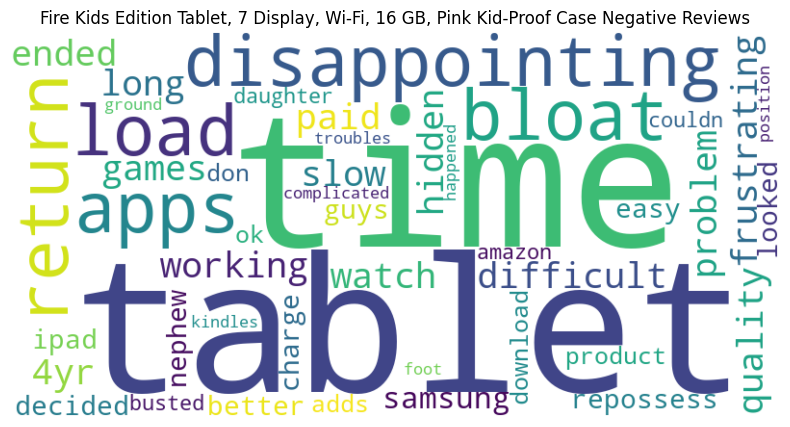

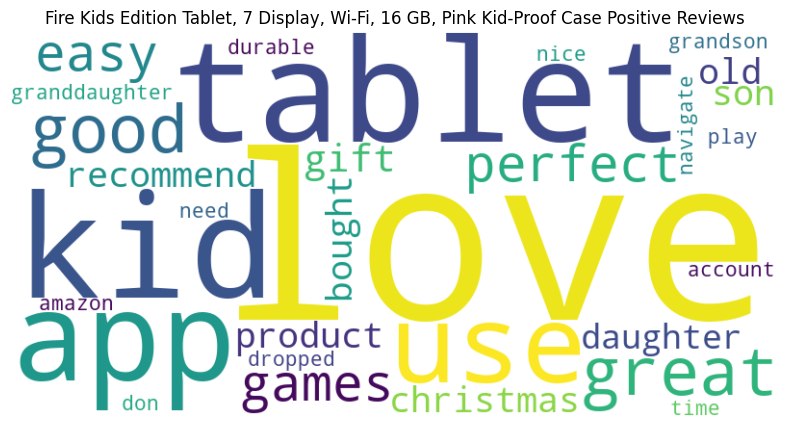

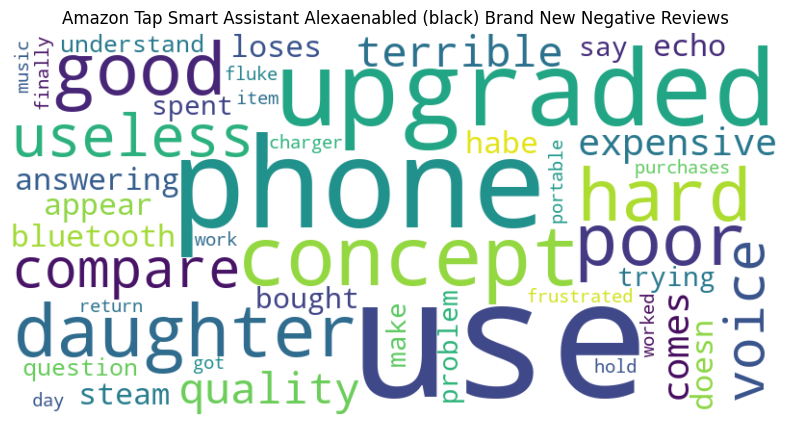

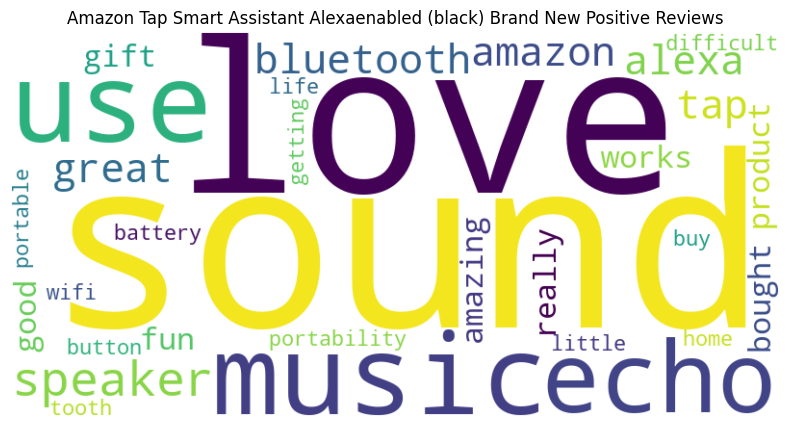

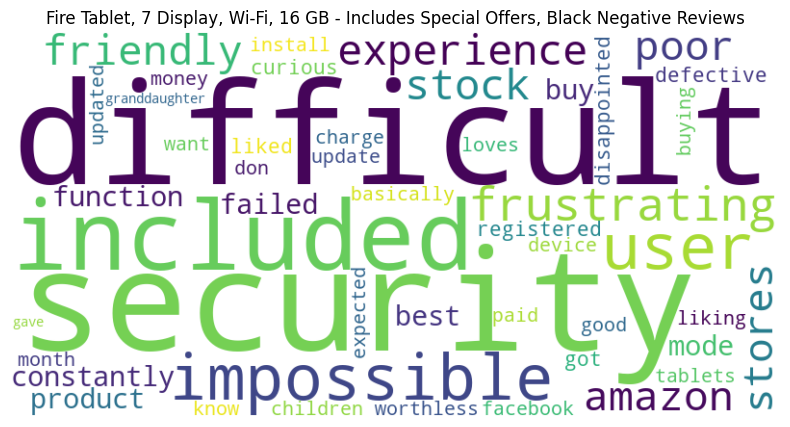

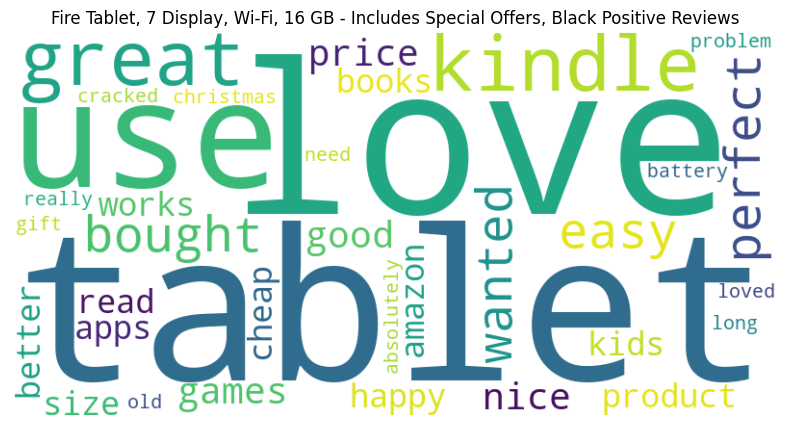

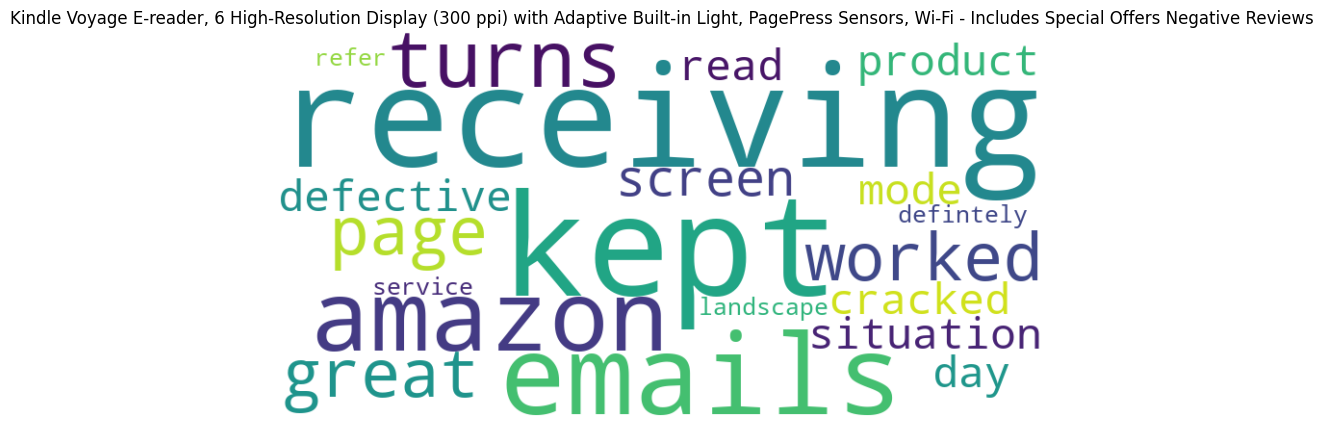

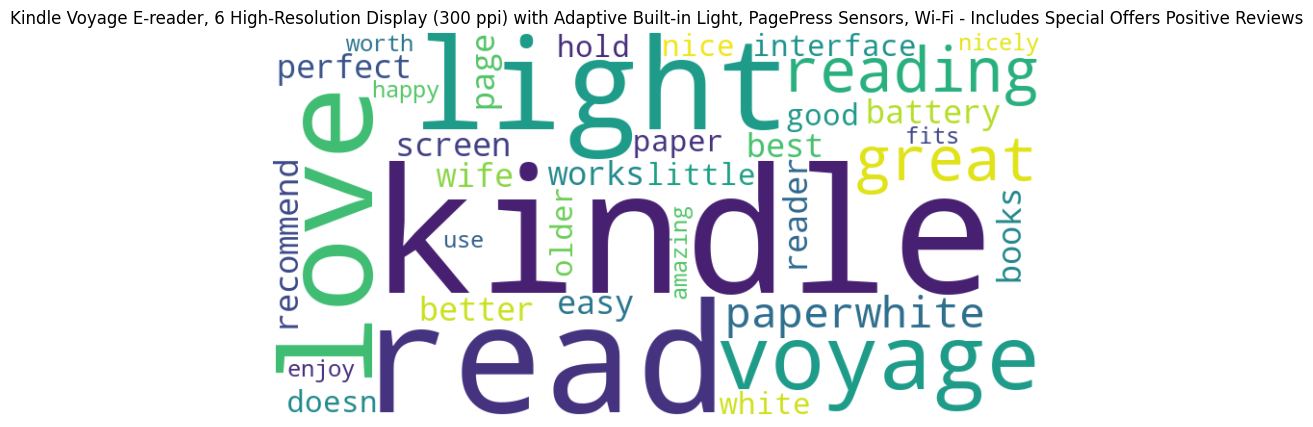

In [ ]:

for productAsin in products_with_more_than_1000_reviews:
    product=review_df_cleaned[review_df_cleaned['asins']==productAsin].copy()
    product.reset_index(inplace=True)
    cons=product[product['reviews.rating']<=3]['reviews.text'].values
    keywords= generateTopKeywords(cons)
    topic_info=generateTopics(keywords)
    generateWordCloud(topic_info,product['name'][0],isPositive=False)
    
    pros=product[product['reviews.rating']>3]['reviews.text'].values
    keywords= generateTopKeywords(pros)
    topic_info=generateTopics(keywords)
    generateWordCloud(topic_info,product['name'][0],isPositive=True)


In [185]:
productReviewSummary=[]
for productAsin in products_with_more_than_1000_reviews:
    print(productAsin)
    product=review_df_cleaned[review_df_cleaned['asins']==productAsin].copy()
    product.reset_index(inplace=True)
    # print(product.head(5))
    cons=product[product['reviews.rating']<3]['reviews.text'].values
    pros= product[product['reviews.rating']>3]['reviews.text'].values
    cons_summary=   generateSummary(cons, productName=product['name'][0])
    pros_summary= generateSummary(pros,productName=product['name'][0])
    cons_count=len(cons)
    pros_count=len(pros)
    tot_count=cons_count+pros_count
    cons_count_percent= np.round(cons_count*100.00/tot_count,0)
    pros_count_percent= np.round(pros_count*100.00/tot_count,0)
    productReviewSummary.append( {
        "productName" : product['name'][0],
        "pros_percentage": pros_count_percent,
        "cons_percentage": cons_count_percent,
        "pros" : pros_summary,
        "cons" : cons_summary
    })

B018Y229OU
B00QWO9P0O,B00LH3DMUO
B00L9EPT8O,B01E6AO69U
B00U3FPN4U
B00QWO9P0O,B01IB83NZG,B00MNV8E0C
B01AHB9CN2
B00OQVZDJM
B018Y23MNM
B018Y225IA
B018T075DC
B018SZT3BK,B01AHB9CN2
B018Y22C2Y
B018Y226XO
B01BH83OOM
B018Y22BI4
B00IOY8XWQ


In [376]:
pd.DataFrame(productReviewSummary)

productName  pros_percentage  \
0   Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...             97.0   
1   AmazonBasics AAA Performance Alkaline Batterie...             90.0   
2                  Echo (White),,,\r\nEcho (White),,,             99.0   
3                                                 NaN             99.0   
4   AmazonBasics AA Performance Alkaline Batteries...             90.0   
5   All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...             98.0   
6   Amazon Kindle Paperwhite - eBook reader - 4 GB...             99.0   
7   Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...             97.0   
8   Fire Tablet with Alexa, 7 Display, 16 GB, Blue...             96.0   
9   Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...             98.0   
10  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...             98.0   
11  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...             97.0   
12  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...             97.0   
13  Amazon Tap Smart Assistant Alexaenabled (black...             96.0   
14  Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...             96.0   
15  Kindle Voyage E-reader, 6 High-Resolution Disp...             99.0   

    cons_percentage                                               pros  \
0               3.0  This tablet offers excellent value, making it ...   
1              10.0  These AmazonBasics AAA alkaline cells offer ex...   
2               1.0  This device makes playing music at home effort...   
3               1.0  This device is highly regarded, offering an ex...   
4              10.0  These AmazonBasics alkaline cells offer a cost...   
5               2.0  This tablet offers a great user experience, ma...   
6               1.0  This e-reader is highly praised for its overal...   
7               3.0  This tablet is a fantastic, durable device tha...   
8               4.0  This device is an excellent and affordable opt...   
9               2.0  This tablet is an excellent and affordable gif...   
10              2.0  This tablet offers an excellent reading experi...   
11              3.0  Children absolutely adore this device, enjoyin...   
12              3.0  This tablet is highly cherished by children an...   
13              4.0  This portable speaker offers an amazing audio ...   
14              4.0  This device is highly regarded for its afforda...   
15              1.0  This e-reader offers an amazing reading experi...   

                                                 cons  
0   While affordable, this device is hindered by i...  
1   These AmazonBasics AAA batteries are frequentl...  
2   Users often experience constant frustration du...  
3   This device from Amazon is prone to lagging, f...  
4   These AmazonBasics AA batteries offer a cost-e...  
5   This tablet handles various applications well,...  
6   This device offers good portability for readin...  
7   This tablet offers a kid-friendly experience, ...  
8   This Fire Tablet struggles with battery life, ...  
9   This tablet is not a suitable alternative to m...  
10  The tablet offers an improved user experience ...  
11  This tablet offers a friendly experience for t...  
12  This tablet often struggles with app functiona...  
13  This device offers a good concept for its user...  
14  The device offers a less-than-optimal user exp...  
15  While generally a good e-reader, some users ex...

In [ ]:

from IPython.display import HTML
html_content = """
<div style="font-family: Arial, sans-serif; max-width: 800px; padding: 20px; border: 1px solid #ddd; border-radius: 10px; background-color: #f9f9f9;">
  <h2 style="color: #c2185b;">Product: Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta</h2>
  <p><strong>Positive:</strong> 97% &nbsp;&nbsp;&nbsp; <strong>Negative:</strong> 3%</p>
  
  <h3 style="color: #2e7d32;">Pros:</h3>
  <p>
    This tablet offers excellent value, making it a highly satisfactory purchase for various users. Its user-friendliness and affordable price point contribute to a positive experience. It is a popular gift choice, particularly for children, who greatly enjoy it. The device is versatile and easy to operate, suitable for games and general use. Overall, this Amazon tablet is an economical and practical option for entertainment and basic applications.
  </p>
  
  <h3 style="color: #d32f2f;">Cons:</h3>
  <p>
    While affordable, this device is hindered by intrusive advertisements and a frequently unresponsive display. Its performance is notably sluggish, with poor internet connectivity and a fragile screen prone to cracking. Many users found its limited app store frustrating, making it unsuitable for their needs and often leading to returns. Despite its attractive price, the tablet's functionality is limited, making it a questionable purchase unless specific Google apps are not required. Overall, it's a decent, budget-friendly option, especially as a gift for children, though its limitations should be considered.
  </p>
</div>
"""

display(HTML(html_content))


In [391]:
from IPython.display import HTML
html_content = """
<div style="font-family: Arial, sans-serif; max-width: 800px; padding: 20px; border: 1px solid #ddd; border-radius: 10px; background-color: #f9f9f9;">
  <h2 style="color: #c2185b;">Product: Echo (White)</h2>
  <p><strong>Positive:</strong> 99% &nbsp;&nbsp;&nbsp; <strong>Negative:</strong> 1%</p>
  
  <h3 style="color: #2e7d32;">Pros:</h3>
  <p>
    This device makes playing music at home effortless through voice commands. Its sound quality is excellent, making it a highly recommended product. The unit is user-friendly, allowing for easy interaction with its virtual assistant. It's a popular gift choice, bringing joy to many households. Overall, this home assistant simplifies daily tasks and entertainment needs.
  </p>
  
  <h3 style="color: #d32f2f;">Cons:</h3>
  <p>Users often experience constant frustration due to unanswered queries and a lack of information. Its utility is limited, with sporadic connectivity issues hindering its basic functions. Many find Alexa's responses unhelpful and disappointing, making the device seem ineffective. Despite initial enthusiasm, some have found the product to be inferior compared to other smart home devices. Furthermore, it often fails to provide comprehensive answers, especially when compared to alternative digital assistants.
  </p>
</div>
"""

display(HTML(html_content))


In [188]:
pd.DataFrame(productReviewSummary).to_csv("productReviewSummary.csv")

### Conclusion

 